In [1]:
import pandas
import numpy
import geopandas
import matplotlib.pyplot as plt
import geopy
%matplotlib inline

# Read in the Austin 311 data
It's in the `data` folder, called `austin_311`. 

In [2]:
reports = pandas.read_csv('../../data/austin_311.csv.gz')

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
reports.head()

,request_number,type_code,description,department,method_received,status,location,street_number,street_name,zipcode,latitude,longitude
0,16-00108244,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),"6001 MANCHACA RD, AUSTIN, TX 78745",6001,MANCHACA,78745.0,30.212695,-97.801522
1,16-00108269,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),"6001 MANCHACA RD, AUSTIN, TX 78745",6001,MANCHACA,78745.0,30.212695,-97.801522
2,16-00324071,SWSDEADA,ARR Dead Animal Collection,Austin Resource Recovery,Phone,Closed,"2200 E OLTORF ST, AUSTIN, TX 78741",2200,OLTORF,78741.0,30.230164,-97.731776
3,16-00108062,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),"8401 N CAPITAL OF TEXAS HWY NB, AUSTIN, TX 78759",8401,CAPITAL OF TEXAS,78759.0,30.384989,-97.766471
4,16-00107654,STREETL2,Street Light Issue- Address,Austin Energy Department,Phone,Closed,"300 WEST AVE, AUSTIN, TX 78703",300,WEST,78703.0,30.268090,-97.751739


## What are the 10 most common types of events in the data?

In [4]:
reports.groupby('type_code').type_code.count().sort_values(ascending=False).head(10)

type_code
CODECOMP    121953
ACLONAG      35776
SWSRECYC     32610
ACINFORM     30093
SWSDEADA     28561
STREETL2     24070
SWSYARDT     22930
COAACINJ     19681
HHSGRAFF     19406
WWREPORT     15192
Name: type_code, dtype: int64

## Fixing missing latitude/longitude values
1. how many records have a missing latitude/longitude pair? 
2. using the `location` field and the geocoding tools we discussed before, create latitude/longitude pairs for the records with missing `latitude` and `longitude` values.
3. update your dataframe with the new geocoded `longitude` and `latitude` values.
4. show that there is no missing latitude/longitude values in the updated data.

In [5]:
missing_coordinates = reports.latitude.isnull() | reports.longitude.isnull()

In [6]:
missing_coordinates.sum()

5

In [7]:
import geopy

In [8]:
coder = geopy.Nominatim(user_agent='scipy2019-intermediate-gds')

In [9]:
def latlng(address):
    coded = coder.geocode(address)
    return coded.latitude, coded.longitude

In [10]:
reports[missing_coordinates].location

224035           10008 DORSET DR, AUSTIN, TX
259989    2400 E OLTORF ST, AUSTIN, TX 78741
340148       506 ZENNIA ST, AUSTIN, TX 78751
378492       2006 S 6TH ST, AUSTIN, TX 78704
486128    1414 WESTOVER RD, AUSTIN, TX 78703
Name: location, dtype: object

In [11]:
locations = reports[missing_coordinates].location.apply(latlng).apply(pandas.Series)

In [12]:
reports.loc[missing_coordinates, 'latitude'] = locations[0]
reports.loc[missing_coordinates, 'longitude'] = locations[1]

In [13]:
reports.latitude.isnull().any() | reports.longitude.isnull().any()

False

## Fixing missing addresses

1. how many records are missing `location` field entries?
2. using the `latitude` and `longitude` fields, find the street locations for the records with missing `location` values. 
3. update your dataframe with the new `location` values. (**BONUS: Update the `street_number`, `street_name`, and `zipcode` if you can, too**)
4. show that there are no more missing `location` values in your data. 

In [14]:
missing_locations = reports.location.isnull()

In [15]:
missing_locations.sum()

13

In [16]:
def reverse(coordinate):
    return coder.reverse(coordinate).address

In [17]:
locations = reports.loc[missing_locations,['latitude','longitude']].apply(reverse, axis=1)
locations

23659     West Gate Boulevard, Pheasant Run, Austin, Tra...
73195     11509, January Drive, Walnut Ridge, Austin, Tr...
142636    800, Gullett Street, Govalle, Austin, Travis C...
180796    6205, Shoal Creek Boulevard, Allandale, Austin...
214871    3300, Burleson Road, Parker Lane, Austin, Trav...
267054    10400, Charette Cove, Prominent Point, Jollyvi...
366275    9725, Spanish Wells Drive, Jollyville, Austin,...
421322    3902, Carmel Drive, MLK, Austin, Travis County...
441041    1528, Payton Falls Drive, Four Seasons, Austin...
476115    1615, Rutherford Lane, Berkley Square - Headwa...
491802    3930, Bee Caves Road, Ledgeway, West Lake Hill...
536128    6913, Wentworth Drive, Loma Vista, Austin, Tra...
562261    600, North Marly Way, Austin Lake Hills, Travi...
dtype: object

In [18]:
reports.loc[missing_locations, ['location']] = locations

In [19]:
def maybe_get_first_number(splitstring):
    try:
        return int(splitstring[0])
    except ValueError:
        return numpy.nan

In [20]:
street_numbers = locations.str.split(',').apply(maybe_get_first_number)

In [21]:
def maybe_get_streetname(splitstring):
    try:
        int(splitstring[0])
        return splitstring[1]
    except ValueError:
        return splitstring[0]

In [22]:
street_names = locations.str.split(',').apply(maybe_get_streetname)

In [23]:
street_names

23659        West Gate Boulevard
73195              January Drive
142636            Gullett Street
180796     Shoal Creek Boulevard
214871             Burleson Road
267054             Charette Cove
366275       Spanish Wells Drive
421322              Carmel Drive
441041        Payton Falls Drive
476115           Rutherford Lane
491802            Bee Caves Road
536128           Wentworth Drive
562261           North Marly Way
dtype: object

In [24]:
zipcodes = locations.str.split(',').apply(lambda split: split[-2])

In [25]:
zipcodes

23659            78748
73195            78753
142636           78702
180796           78757
214871           78741
267054           78759
366275           78717
421322           78721
441041           78754
476115     78753:78754
491802           78746
536128           78724
562261           78733
dtype: object

In [26]:
reports.loc[missing_locations, ['street_number']] = street_numbers
reports.loc[missing_locations, ['street_name']] = street_names
reports.loc[missing_locations, ['zipcode']] = zipcodes

In [27]:
reports.location.isnull().any()

False

# Check miscoded latitude, longitude values. 

Use the total bounds of the austin neighborhoods data to identify observations that may be mis-coded as outside of Austin.


In [28]:
neighborhoods = geopandas.read_file('../../data/neighborhoods.gpkg')

In [29]:
known_bounds = neighborhoods.total_bounds
known_bounds

array([-98.071453,  30.068439, -97.541566,  30.521356])

In [30]:
too_far_ns = (reports.latitude < known_bounds[1]) | (reports.latitude > known_bounds[3])
too_far_we = (reports.longitude < known_bounds[0]) | (reports.longitude > known_bounds[2])
outside = too_far_ns | too_far_we

In [31]:
outside.sum()

3365

In [32]:
reports = reports[~outside]

## Remove duplicate reports

311 data is very dirty. Let's keep only tickets whose `status` suggests they're reports with full information that are not duplicated. 

In [33]:
reports.status.unique()

array(['Duplicate (closed)', 'Closed', 'Open', 'New', 'Resolved',
       'Closed -Incomplete Information', 'Duplicate (open)',
       'Work In Progress', 'Transferred', 'TO BE DELETED', 'Pending',
       'CancelledTesting', 'Closed -Incomplete', 'Incomplete'],
      dtype=object)

In [34]:
to_drop = ('Duplicate (closed)', 'Closed -Incomplete Information', 'Duplicate (open)', 
           'TO BE DELETED', 'CancelledTesting', 'Closed -Incomplete', 'Incomplete')
reports = reports.query('status not in @to_drop')

In [35]:
reports.status.unique()

array(['Closed', 'Open', 'New', 'Resolved', 'Work In Progress',
       'Transferred', 'Pending'], dtype=object)

## Build a GeoDataFrame from the locations

In [36]:
reports = geopandas.GeoDataFrame(reports, geometry=geopandas.points_from_xy(reports.longitude, 
                                                                            reports.latitude))

# Make a map of the report instances with a basemap

In [37]:
import contextily

In [38]:
reports.crs = {'init':'epsg:4326'}
reports = reports.to_crs(epsg=3857)

In [39]:
basemap, basemap_extent = contextily.bounds2img(*reports.total_bounds, zoom=10, ll=False)

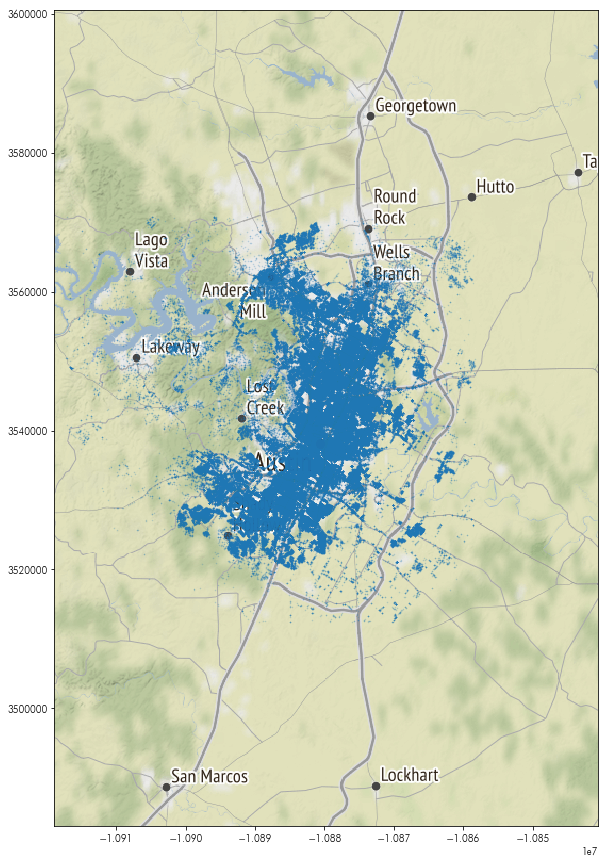

In [40]:
plt.figure(figsize=(15,15))
plt.imshow(basemap, extent=basemap_extent)
reports.plot(ax=plt.gca(), marker='.', markersize=1, alpha=.25)

In [41]:
reports.shape

(555497, 13)

## How many incidents with the Public Health department are within each neighborhood?

In [42]:
reports.department.unique()

array(['Austin Resource Recovery', 'Austin Energy Department',
       'Transportation', 'Animal Services Office',
       'Austin Code Department', 'Parks & Recreation Department',
       'Economic Development Department', 'Austin Water Utility',
       'Public Works', 'Health & Human Services', 'Watershed Protection',
       'Austin Water', 'Public Health',
       'Neighborhood Housing & Community Development',
       'Austin Fire Department', 'Neighborhood Housing & Community',
       'Office of Emergency Management'], dtype=object)

In [43]:
health = reports.query('department == "Public Health" '
              'or department == "Health & Human Services"')

array([-10916755.97016249, -10858605.25412386,   3512792.57783966,
         3570235.76893318])

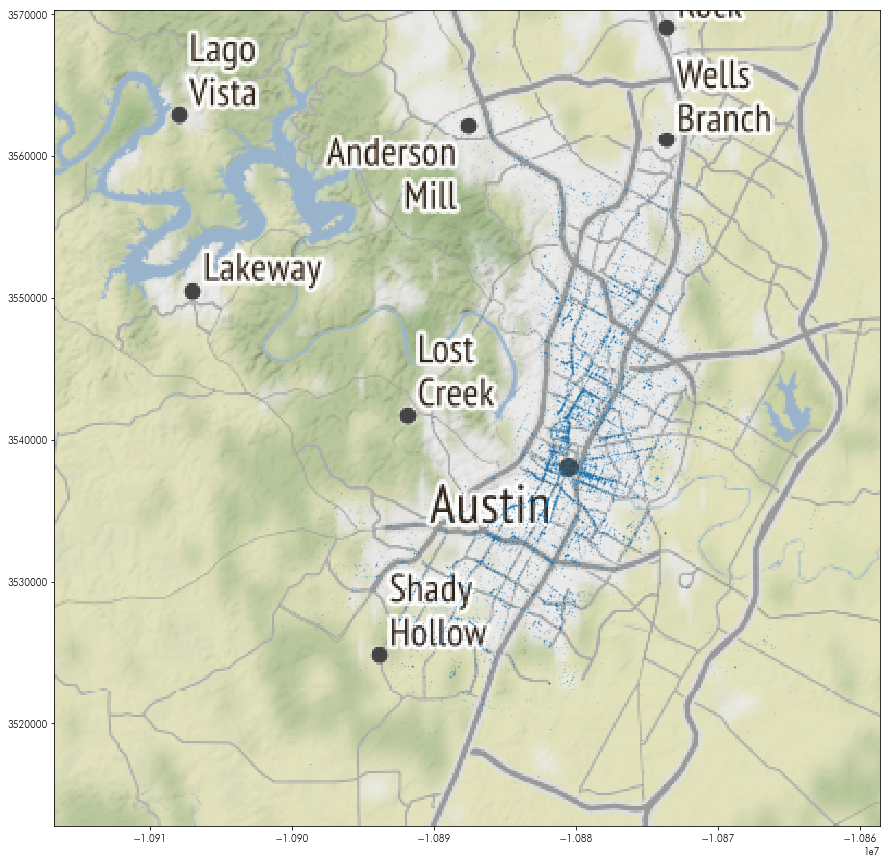

In [44]:
plt.figure(figsize=(15,15))
plt.imshow(basemap, extent=basemap_extent)
health.plot(ax=plt.gca(), marker='.', markersize=1, alpha=.25)
plt.axis(health.total_bounds[[0,2,1,3]])

In [45]:
neighborhoods = neighborhoods.to_crs(epsg=3857)

In [46]:
hood_counts = geopandas.sjoin(neighborhoods, health, op='contains')\
                       .groupby('hood_id').index_right.count()
neighborhoods['health_incidents'] = hood_counts.values

array([-10916755.97016249, -10858605.25412386,   3512792.57783966,
         3570235.76893318])

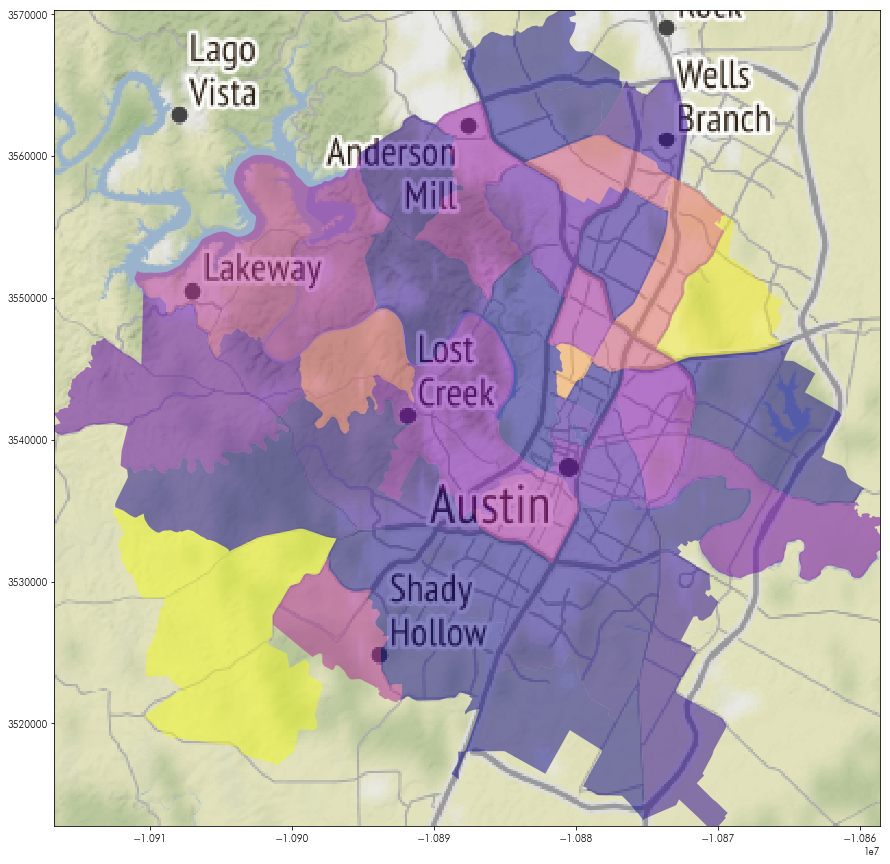

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(basemap, extent=basemap_extent)
neighborhoods.plot('health_incidents', ax=plt.gca(), 
                   cmap='plasma', alpha=.5)
plt.axis(health.total_bounds[[0,2,1,3]])

# How many public health events are within 1km of each airbnb downtown?

In [48]:
listings = geopandas.read_file('../../data/listings.gpkg')
listings = listings.to_crs(epsg=3857)
downtown_hoods = ('Downtown', 'East Downtown')
downtown_listings = listings.query('hood in @downtown_hoods').sort_values('id')
downtown_listings['buffer'] = downtown_listings.buffer(1000)
within_each_buffer = geopandas.sjoin(downtown_listings.set_geometry('buffer'), 
                                     health, op='contains')

In [49]:
event_counts = within_each_buffer.groupby('id').request_number.count()

In [50]:
downtown_listings['event_counts'] = event_counts.values

In [51]:
downtown_listings.sort_values('event_counts', ascending=False).head(5)[['id', 'name', 'event_counts']]

,id,name,event_counts
9950,30853001,"Hip, Trendy Eastside Suite - 5min from Downtown",1159
6294,20971212,Awesome Eastside Rental,1158
9084,28463789,"Inn Cahoots: 3 combined units, 39 beds on 6th St",1135
10991,32833881,Airy 1BR in East Austin by Sonder,1130
10494,32203710,East Austin Loft,1127


In [52]:
downtownmap, downtownmap_extent = contextily.bounds2img(*downtown_listings.buffer(1000).total_bounds, 
                                                        zoom=13, ll=False)

Text(0.5, 1.0, '311 Public Health incidents')

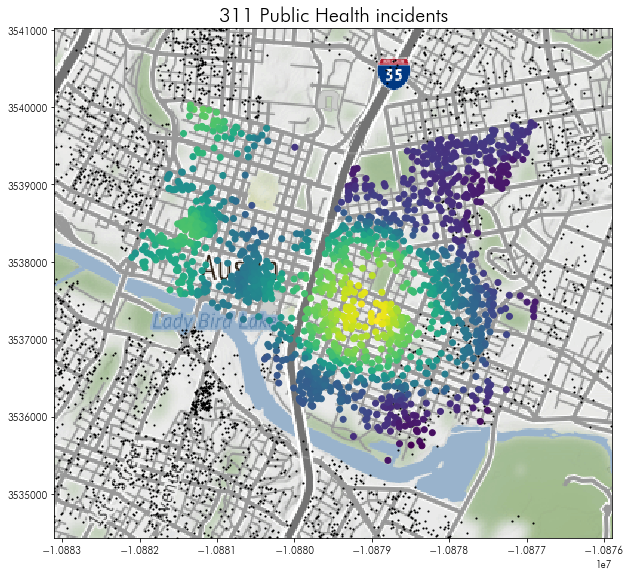

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(downtownmap, extent=downtownmap_extent)
listings.plot(color='k', marker='.', markersize=5, ax=plt.gca())
downtown_listings.plot('event_counts', ax=plt.gca())
plt.axis(downtown_listings.buffer(1000).total_bounds[[0,2,1,3]], markersize=5)
plt.title('311 Public Health incidents', fontsize=20)

# What's the event type that is closest to each airbnb in Austin?

In [54]:
from pysal.lib.weights.distance import get_points_array
from scipy.spatial import cKDTree

In [55]:
report_coordinates = get_points_array(reports.geometry)
airbnb_coordinates = get_points_array(listings.geometry)

In [56]:
report_kdt = cKDTree(report_coordinates)

In [57]:
distances, indices = report_kdt.query(airbnb_coordinates, k=2)

In [58]:
listings['nearest_type'] = reports.iloc[indices[:,1]]['description'].values

In [59]:
listings.groupby('nearest_type').id.count().sort_values(ascending=False).head(20)

nearest_type
Austin Code - Request Code Officer              2165
ARR Missed Recycling                             758
Street Light Issue- Address                      584
Animal Control - Assistance Request              562
ARR Dead Animal Collection                       523
Loose Dog                                        517
Injured / Sick Animal                            480
Water Waste Report                               336
Pothole Repair                                   282
Graffiti Abatement                               276
ARR Missed Yard Trimmings /Organics              256
ARR Brush and Bulk                               221
Traffic Signal - Dig Tess Request                218
Austin Code - Short Term Rental Complaint SR     217
Found Animal Report - Keep                       212
ARR Missed Yard Trimmings/Compost                212
Loud Commercial Music                            178
Wildlife Exposure                                173
Public Health - Graffiti Abatemen